<a href="https://colab.research.google.com/github/Kasi-redddy/Ayna-project/blob/main/Ayna_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision wandb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.8 MB/s eta 0:00:00


In [2]:
!unzip -o dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/training/
   creating: dataset/validation/
  inflating: dataset/training/data.json  
   creating: dataset/training/outputs/
   creating: dataset/training/inputs/
  inflating: dataset/validation/data.json  
   creating: dataset/validation/outputs/
   creating: dataset/validation/inputs/
  inflating: dataset/training/outputs/green_octagon.png  
  inflating: dataset/training/outputs/blue_hexagon.png  
  inflating: dataset/training/outputs/green_diamond.png  
  inflating: dataset/training/outputs/cyan_triangle.png  
  inflating: dataset/training/outputs/purple_square.png  
  inflating: dataset/training/outputs/orange_pentagon.png  
  inflating: dataset/training/outputs/magenta_circle.png  
  inflating: dataset/training/outputs/blue_triangle.png  
  inflating: dataset/training/outputs/red_pentagon.png  
  inflating: dataset/training/outputs/magen

In [3]:
import os
print(os.listdir('dataset'))
print(os.listdir('dataset/training'))
print(os.listdir('dataset/validation'))

['.DS_Store', 'training', 'validation']
['outputs', 'inputs', 'data.json']
['outputs', 'inputs', 'data.json']


In [4]:
import json
data_sample = json.load(open('dataset/training/data.json'))
print(data_sample[0])

{'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}


In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

COLOR_LIST = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'purple']
COLOR_TO_IDX = {c: i for i, c in enumerate(COLOR_LIST)}

img_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),             # keep [0,1]
])
target_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

class PolygonDataset(Dataset):
    def __init__(self, input_dir, output_dir, data_json, img_transform, tgt_transform):
        with open(data_json) as f:
            self.data = json.load(f)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.img_transform = img_transform
        self.target_transform = tgt_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = Image.open(os.path.join(self.input_dir, item['input_polygon'])).convert('L')
        tgt = Image.open(os.path.join(self.output_dir, item['output_image'])).convert('RGB')
        color_idx = COLOR_TO_IDX[item['colour']]
        img = self.img_transform(img)
        tgt = self.target_transform(tgt)
        return img, color_idx, tgt

# Instantiate dataloader
train_dataset = PolygonDataset(
    'dataset/training/inputs/',
    'dataset/training/outputs/',
    'dataset/training/data.json',
    img_transform,
    target_transform
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


Color index: 4


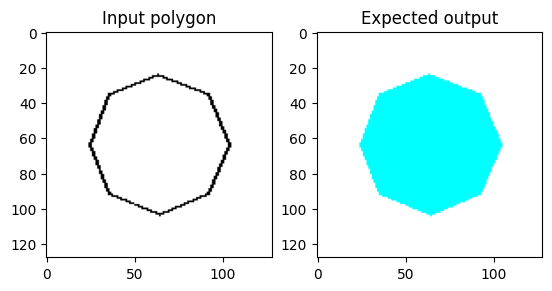

In [6]:
import matplotlib.pyplot as plt
img, color_idx, tgt = train_dataset[0]
print("Color index:", color_idx)
plt.subplot(1,2,1)
plt.imshow(img[0], cmap='gray')
plt.title('Input polygon')
plt.subplot(1,2,2)
plt.imshow(tgt.permute(1,2,0))
plt.title('Expected output')
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        return self.seq(x)

class UNet(nn.Module):
    def __init__(self, n_colors, emb_dim=8):
        super().__init__()
        self.color_emb = nn.Embedding(n_colors, emb_dim)
        self.down1 = DoubleConv(1 + emb_dim, 32)
        self.down2 = DoubleConv(32, 64)
        self.down3 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.conv_up1 = DoubleConv(128, 64)
        self.conv_up2 = DoubleConv(64, 32)
        self.final_conv = nn.Conv2d(32, 3, 1)

    def forward(self, x, color_idx):
        emb = self.color_emb(color_idx)
        emb = emb[:, :, None, None].expand(-1, -1, x.shape[2], x.shape[3])
        x = torch.cat([x, emb], 1)
        x1 = self.down1(x)
        x2 = self.down2(self.pool(x1))
        x3 = self.down3(self.pool(x2))
        u1 = self.up1(x3)
        u1 = torch.cat([u1, x2], 1)
        u1 = self.conv_up1(u1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, x1], 1)
        u2 = self.conv_up2(u2)
        return self.final_conv(u2)


In [8]:
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_colors=len(COLOR_LIST), emb_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

wandb.init(project='aynapolygon_ml_intern')

for epoch in range(15):
    model.train()
    running_loss = 0.0
    for imgs, color_idxs, targets in train_loader:
        imgs = imgs.to(device)
        color_idxs = color_idxs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, color_idxs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    wandb.log({'epoch': epoch, 'loss': avg_loss})
    print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kasivisweswarreddy6 (kasivisweswarreddy6-bharath-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1: Loss 1.0418
Epoch 2: Loss 0.7519
Epoch 3: Loss 0.5619
Epoch 4: Loss 0.4279
Epoch 5: Loss 0.3298
Epoch 6: Loss 0.2468
Epoch 7: Loss 0.1971
Epoch 8: Loss 0.1620
Epoch 9: Loss 0.1345
Epoch 10: Loss 0.1187
Epoch 11: Loss 0.1146
Epoch 12: Loss 0.0978
Epoch 13: Loss 0.0945
Epoch 14: Loss 0.0895
Epoch 15: Loss 0.0868


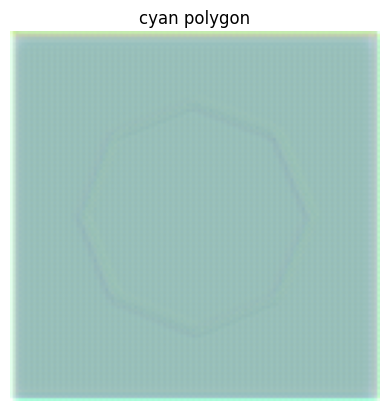

In [9]:
def infer_and_show(model, img_path, color_name):
    model.eval()
    with torch.no_grad():
        img = Image.open(img_path).convert('L')
        img = img_transform(img).unsqueeze(0).to(device)
        color_idx = torch.tensor([COLOR_TO_IDX[color_name]]).to(device)
        output = model(img, color_idx)
        out_img = output.squeeze(0).permute(1,2,0).cpu().numpy().clip(0,1)
        plt.imshow(out_img)
        plt.title(f"{color_name} polygon")
        plt.axis('off')
        plt.show()

# Try on a validation sample:
infer_and_show(model, 'dataset/validation/inputs/octagon.png', 'cyan')


In [10]:
torch.save(model.state_dict(), "colored_polygon_unet.pth")